In [ ]:
import flopy as fp
import geopandas as gp 
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pathlib import Path
import numpy as np
import pyemu
import platform, shutil

### Set a couple paths to information we will need

In [ ]:
#### Base directory for runs
parent_run_path = Path("../../LPR_pycap_opt/pycap_runs")

#### depletion potential calculations directory
base_run_path = parent_run_path / "pycap_base"

#### modflow base path
modflow_run_path = Path('../steady_state_mf6')

#### modflow depletion potential calculations directory
modflow_dp_path = Path('../steady_state_mf6_DP')


### read in the depletion potetial as calculated by `pycap`

In [ ]:
dp = gp.read_file(base_run_path / 'depletion_potential.json').to_crs(3071)

/Users/mnfienen/miniforge3/envs/pycap/lib/python3.11/site-packages/pyogrio/__init__.py:7: DeprecationWarning: The 'shapely.geos' module is deprecated, and will be removed in a future version. All attributes of 'shapely.geos' are available directly from the top-level 'shapely' namespace (since shapely 2.0.0).


### now read in the MODFLOW-6 version of the steady-state Little Plover River Model

In [ ]:
sim = fp.mf6.MFSimulation.load(sim_ws = '../steady_state_mf6')
m = sim.get_model()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package sfr...
    loading package ic...
    loading package npf...
    loading package oc...
    loading package rch...
    loading package chd...
    loading package drn...
    loading package wel...
  loading solution package lpr_ss_gwf...


### We will need a `modelgrid` object to locate wells and gages on the MODFLOW grid

In [ ]:
modelgrid = fp.discretization.StructuredGrid(xoff=1795400*.3048,  
                                             yoff=1424400*.3048,
                                             botm=m.dis.botm.array,
                                             delr = m.dis.delr.array*.3048,
                                             delc = m.dis.delc.array*.3048,
                                                
                                             crs=3071)


### We can look at the main boundaries

Text(0, 0.5, 'Undefined northing, NAD83(HARN) / Wisconsin Transverse Mercator')

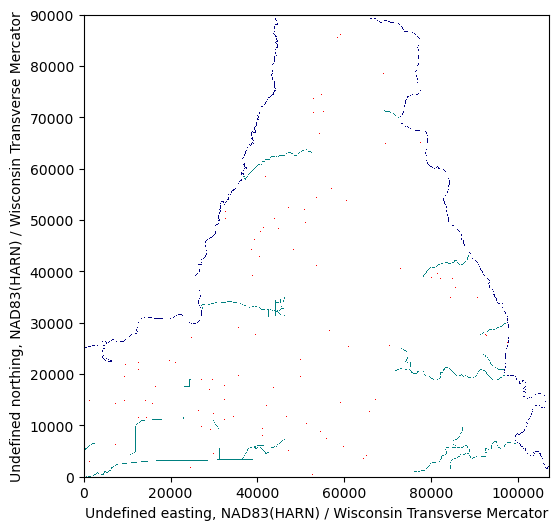

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
pmv = fp.plot.PlotMapView(m, ax=ax)
# lc = pmv.plot_grid(lw=0.5)
pmv.plot_bc("WEL", plotAll=True)
pmv.plot_bc("SFR", plotAll=True)
pmv.plot_bc("CHD", plotAll=True)
ax.set_xlabel(f'{modelgrid.units.capitalize()} easting, {modelgrid.crs.name}')
ax.set_ylabel(f'{modelgrid.units.capitalize()} northing, {modelgrid.crs.name}')

### Let's write out the grid as a shapefile and then explore the model 

In [ ]:
modelgrid.write_shapefile('grid.shp')
grid_shp = gp.read_file('grid.shp').set_crs(3071)
mf6outline = grid_shp.dissolve()

In [ ]:
mmap=mf6outline.explore()
dp.explore(column="Depletion_Potential",
                  vmin=0,vmax=1,m=mmap,
                  style_kwds={"style_function":
                                  lambda x: 
                                  {"radius":x["properties"]["Depletion_Potential"]*15}})


## let's choose a well to compare between MODFLOW and pycap for depletion potential

In [ ]:
# choose a well number from the map above. Then make sure `wellrc` below is only one row. If it's more than one, choose another well
eval_well = '69049'

In [ ]:
wellrc = gp.sjoin(dp.loc[dp.name==eval_well],
         grid_shp,
         how='inner',
         predicate='intersects')
wellrc

,index,name,Q_gpm,Q_cfs,DEPL_cfs,Depletion_Potential,geometry,index_right,node,row,column
229,well_69049,69049,37.6,0.083773,0.039051,0.466146,POINT (561700.3 445803.63),553664,553665,518,475


In [ ]:
assert len(wellrc)==1

### SUPER IMPORTANT NOTE!
#### Indexing of layers, rows and columns starts at 1 in MODFLOW, but starts at 0 in python as a result, you must add 1 to any layer, row, or column index seen in this python notebook if you plan to update a MODFLOW file directly

#### Working with `MODFLOW` and `flopy` / `python` requires shifting between these index conventions so you will see +1 and -1 associated with indices throughout this notebook. For example, the `grid.shp` file made above is in MODFLOW coordinated (1-based) so interacting with the `wells` DataFrame in python requires a `-1` be applied.

In [ ]:
wells = pd.DataFrame.from_records(m.wel.stress_period_data.array[0])
wells['l'] = [i[0] for i in wells.cellid]
wells['r'] = [i[1] for i in wells.cellid]
wells['c'] = [i[2] for i in wells.cellid]
wells

,cellid,q,l,r,c
0,"(0, 638, 975)",-1483.065800,0,638,975
1,"(1, 638, 975)",-7071.723140,1,638,975
2,"(0, 751, 93)",-8784.499020,0,751,93
3,"(1, 751, 93)",-8431.159180,1,751,93
4,"(1, 751, 93)",-338.600769,1,751,93
...,...,...,...,...,...
582,"(1, 507, 609)",-5135.377440,1,507,609
583,"(1, 468, 316)",-111317.383000,1,468,316
584,"(2, 468, 316)",-2882.614500,2,468,316
585,"(1, 463, 316)",-10801.613300,1,463,316


#### using the well information from `flopy` let's report the layer to accompany row and column so we can update the well file

In [ ]:
wellrc['layer'] = wells.loc[(wells.r==wellrc.iloc[0].row-1) & (wells.c==wellrc.iloc[0].column-1)].l.values+1

### now we have all the information we will need to update a well file

In [ ]:
wellrc

,index,name,Q_gpm,Q_cfs,DEPL_cfs,Depletion_Potential,geometry,index_right,node,row,column,layer
229,well_69049,69049,37.6,0.083773,0.039051,0.466146,POINT (561700.3 445803.63),553664,553665,518,475,2


### using similar logic, we'll need to locate the "Hoover" gage location to set up an observation of streamflow. The point coordinates were manually pulled off of a GIS coverage as a starting point

In [ ]:
hoover_gage_loc = gp.GeoDataFrame(index=['hoover'],geometry=[Point(557498.46,444568.09)],crs=3071)

In [ ]:
gage_rc  = gp.sjoin(hoover_gage_loc,
         grid_shp,
         how='inner',
         predicate='intersects')

In [ ]:
gage_rc

,geometry,index_right,node,row,column
hoover,POINT (557498.46 444568.09),597396,597397,559,337


### now we can use the streamflow routing (SFR) information from the MODFLOW model to find the segment number for the row/column location found above for the gage

In [ ]:
sfr_lox = pd.DataFrame.from_records(m.sfr.packagedata.array)
sfr_lox['r'] = [i[1] for i in sfr_lox.cellid]
sfr_lox['c'] = [i[2] for i in sfr_lox.cellid]
hoover_reach = sfr_lox.loc[(sfr_lox.r==gage_rc.iloc[0].row-1)& (sfr_lox.c==gage_rc.iloc[0].column-1)].ifno.values[0]

In [ ]:
hoover_reach

np.int64(2786)

### we can make a quick obsevation file for SFR following guidance here:
https://modflow6.readthedocs.io/en/stable/_mf6io/gwf-sfr.html

In [ ]:
with open(modflow_run_path / 'sfr_obs.obs', 'w') as ofp:
    ofp.write('BEGIN OPTIONS\n\tDIGITS 8\n\tPRINT_INPUT\nEND OPTIONS\n\n')
    ofp.write('BEGIN CONTINUOUS FILEOUT hoover.sfr.csv\n')
    ofp.write(f'\thooverflow DOWNSTREAM-FLOW {hoover_reach}\n')
    ofp.write('END CONTINUOUS')

### we also have to update the SFR file to recognize the observation file invocation

In [ ]:
# read in the existing SFR file
sfr_old = [i.rstrip() for i in open(modflow_run_path / 'lpr_ss.sfr.orig','r').readlines()]

In [ ]:
with open(modflow_run_path / 'lpr_ss.sfr','w') as ofp:
    for line in sfr_old:
        if 'begin' in line.lower() and 'options' in line.lower():
            ofp.write('BEGIN Options\n\tOBS6 FILEIN sfr_obs.obs\n')
        else:
            ofp.write(line + '\n')

### now if we run MF6 again, we should generate an observation of flow at hoover

In [ ]:
#copy over the correct binary
if "window" in platform.platform().lower():
    shutil.copy2('../../binaries/MODFLOW6/windows/mf6.exe', modflow_run_path / 'mf6.exe')
elif "linux" in platform.platform().lower():
    shutil.copy2('../../binaries/MODFLOW6/linux/mf6', modflow_run_path / 'mf6')
elif "mac" in platform.platform().lower():
    shutil.copy2('../../binaries/MODFLOW6/mac/mf6', modflow_run_path / 'mf6')

In [ ]:
# RUN! Should take bewteen 2 and 6 minutes
pyemu.os_utils.run('mf6', cwd = str(modflow_run_path))

./mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.3 09/29/2025

        MODFLOW 6 compiled Sep 29 2025 08:22:42 with GCC version 13.4.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources Software User Rights Notice for complete use, copyright, 
and distribution infor

In [ ]:
hoover_q = pd.read_csv(modflow_run_path / 'hoover.sfr.csv')
hoover_q['HOOVERFLOW']

0   -467829.54
Name: HOOVERFLOW, dtype: float64

### this is in CFD (cubic feet per day) so need to convert to CFS

In [ ]:
hoover_q['HOOVERFLOW']/24/60/60

0   -5.414694
Name: HOOVERFLOW, dtype: float64

# Now we need to copy over the folder, update the flow rate, run, and compare. We could do this using `flopy`, but sometimes it's easier to just work directly with the files, in this case using `pandas`

In [ ]:
shutil.copytree(modflow_run_path, modflow_dp_path, dirs_exist_ok=True)

PosixPath('../steady_state_mf6_DP')

#### next we can read in just the well information - let's copy the file first to have a backup in case we make a mistake

In [ ]:
shutil.copy2(modflow_run_path / 'lpr_ss_gwf.wel_stress_period_data_1.txt',
             modflow_dp_path / 'lpr_ss_gwf.wel_stress_period_data_1.txt.BACKUP')

PosixPath('../steady_state_mf6_DP/lpr_ss_gwf.wel_stress_period_data_1.txt.BACKUP')

In [ ]:
wel_data = pd.read_csv(modflow_dp_path / 'lpr_ss_gwf.wel_stress_period_data_1.txt.BACKUP',
                       sep=r"\s+",
                       names=['l','r','c','q'])

In [ ]:
wel_data

,l,r,c,q
0,1,639,976,-1483.065800
1,2,639,976,-7071.723140
2,1,752,94,-8784.499020
3,2,752,94,-8431.159180
4,2,752,94,-338.600769
...,...,...,...,...
582,2,508,610,-5135.377440
583,2,469,317,-111317.383000
584,3,469,317,-2882.614500
585,2,464,317,-10801.613300


In [ ]:
wellrc

,index,name,Q_gpm,Q_cfs,DEPL_cfs,Depletion_Potential,geometry,index_right,node,row,column,layer
229,well_69049,69049,37.6,0.083773,0.039051,0.466146,POINT (561700.3 445803.63),553664,553665,518,475,2


In [ ]:
# let's check out the existing pumping for our candidate well
cwell = wel_data.loc[(wel_data.r==wellrc.row.values[0]) &
             (wel_data.c==wellrc.column.values[0])]
cwell

,l,r,c,q
265,2,518,475,-1165.51062


In [ ]:
wellrc['modflow_pumping_CFD'] = cwell.q.values

In [ ]:
wellrc

,index,name,Q_gpm,Q_cfs,DEPL_cfs,Depletion_Potential,geometry,index_right,node,row,column,layer,modflow_pumping_CFD
229,well_69049,69049,37.6,0.083773,0.039051,0.466146,POINT (561700.3 445803.63),553664,553665,518,475,2,-1165.51062


#### now let's increment the pumping rate by 10X, pump again, and then rerun the model

In [ ]:
wel_data.loc[cwell.index,'q'] *= 10

In [ ]:
wel_data.loc[cwell.index]

,l,r,c,q
265,2,518,475,-11655.1062


In [ ]:
wellrc['modflow_DP_pumping_CFD'] = wel_data.loc[(wel_data.r==wellrc.row.values[0]) &
             (wel_data.c==wellrc.column.values[0])].q.values[0]

In [ ]:
wellrc

,index,name,Q_gpm,Q_cfs,DEPL_cfs,Depletion_Potential,geometry,index_right,node,row,column,layer,modflow_pumping_CFD,modflow_DP_pumping_CFD
229,well_69049,69049,37.6,0.083773,0.039051,0.466146,POINT (561700.3 445803.63),553664,553665,518,475,2,-1165.51062,-11655.1062


### Now write the pumping data back out

In [ ]:
wel_data.to_csv(modflow_dp_path / 'lpr_ss_gwf.wel_stress_period_data_1.txt',
                index=None,
                header=None,
                sep=' ')

### Now run the Depletion Potential Calculations version of the MODFLOW model

In [ ]:
# RUN! Should take bewteen 2 and 6 minutes
pyemu.os_utils.run('mf6', cwd = str(modflow_dp_path))

./mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.3 09/29/2025

        MODFLOW 6 compiled Sep 29 2025 08:22:42 with GCC version 13.4.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources Software User Rights Notice for complete use, copyright, 
and distribution infor

#### Next we read in the hoover gage data from the changed model

In [ ]:
hoover_q_inc = pd.read_csv(modflow_dp_path / 'hoover.sfr.csv')
hoover_q_inc['HOOVERFLOW']/24/60/60

0   -5.346289
Name: HOOVERFLOW, dtype: float64

In [ ]:
d_Q_stream = np.abs(hoover_q['HOOVERFLOW']-hoover_q_inc['HOOVERFLOW'])
d_Q_stream

0    5910.16
Name: HOOVERFLOW, dtype: float64

In [ ]:
wellrc

,index,name,Q_gpm,Q_cfs,DEPL_cfs,Depletion_Potential,geometry,index_right,node,row,column,layer,modflow_pumping_CFD,modflow_DP_pumping_CFD
229,well_69049,69049,37.6,0.083773,0.039051,0.466146,POINT (561700.3 445803.63),553664,553665,518,475,2,-1165.51062,-11655.1062


In [ ]:
dQ_well = (wellrc.modflow_pumping_CFD.values - wellrc.modflow_DP_pumping_CFD.values)[0]
dQ_well

np.float64(10489.595580000001)

### So finally the depletion potential can be calculated as:
$DP=\frac{\Delta Q_{stream}}{\Delta Q_{well}}$

In [ ]:
DP_MODFLOW = d_Q_stream/dQ_well
DP_MODFLOW

0    0.563431
Name: HOOVERFLOW, dtype: float64

#### How does this compare with the value calculated from the analytical solutions in `pycap`?

In [ ]:
print(f"DP from pycap = {wellrc.Depletion_Potential.values[0]}")

DP from pycap = 0.46614646501568746
